# Demand prediction for theme parks (specific case of USS)

In [1]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import simpy
from datetime import datetime, timedelta
import os
os.chdir("C:/Users/parma/data-science-guest-experience/Scripts/Subgroup_B")

## Loading datasets
### Load survey data

What the function does:
- renames question columns for easier reference
- converting wait times to numerical values, taking the median/mean of the range
- adding synthetic event column: USS only has 1 notable special event which is HHN, which is assigned to visitors that came during October - December season. Otherwise, the column is assigned as none. For visitors that forgot the timeline in which they visited, a random value will be assigned.
- handling long wait times: splits attractions that have long wait times into separate observations and assign a baseline wait time which is 90 minutes, for those that felt queueing time was not worth the experience, and 75 for those that do. 
- normalise guest satisfaction score
- process timestamp and extracting date features
- filters for valid attractions, which only keeps popular attractions like: revenge of the mummy, cylon, transformers, etc"
- ensuring required columns are present

In [16]:
def load_survey_data(file_path="../../data/survey.csv"):
    """
    Loads and preprocesses survey data from survey.csv for demand prediction.

    Args:
        file_path (str): Path to the survey CSV file.

    Returns:
        pd.DataFrame: Preprocessed survey data with required columns.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} not found. Please provide the survey dataset.")

    df = pd.read_csv(file_path)
    #print("Columns in survey.csv:", df.columns.tolist())

    df = df.rename(columns={
        "On a scale of 1-5, how would you rate your overall experience at USS?": "Guest_Satisfaction_Score",
        "How long did you wait in line for rides on average during your visit?": "Wait_Time",
        "Timestamp": "Timestamp",
        "Which ride or attraction was your favourite?": "Attraction"
    })

    wait_time_mapping = {
        "Less than 15 mins": 10,
        "15-30 mins": 22.5,
        "30-45 mins": 37.5,
        "45 mins - 1 hr": 52.5,
        "More than 1 hr": 75
    }
    df["Wait_Time"] = df["Wait_Time"].map(wait_time_mapping).fillna(37.5)

    # Synthetic event data (no external event API)
    np.random.seed(42)
    df["Event"] = np.random.choice(['None', 'Special Event'], size=len(df), p=[0.8, 0.2])

    required_columns_for_long_wait = [
        'Attraction', 'Timestamp', 'Event', 'Wait_Time', 'Guest_Satisfaction_Score',
        'Which part of the year did you visit USS?', 'Did you purchase the Express Pass?',
        'What was the main purpose of your visit?', 'Who did you visit USS with?',
        'Which age group do you belong to?'
    ]

    if 'Did you experience any rides with longer-than-expected wait times? If yes, which ride(s)?' not in df.columns:
        print("Warning: Long wait time column missing. Skipping wait time enhancement.")
        long_wait_df = pd.DataFrame(columns=required_columns_for_long_wait)
    else:
        long_wait_rides = df['Did you experience any rides with longer-than-expected wait times? If yes, which ride(s)?'].str.split(', ', expand=True).stack().reset_index()
        long_wait_rides.columns = ['original_index', 'split_index', 'Attraction']
        long_wait_rides = long_wait_rides[long_wait_rides['Attraction'].notna()]

        queue_worth_col = 'Did you feel that overall, the queuing time was worth the experience of the attraction? '
        unpleasant_col = 'What made your experience with this ride or attraction unpleasant? '

        wait_time_adjusted = []
        for idx in long_wait_rides['original_index']:
            if queue_worth_col in df.columns:
                queue_worth = df[queue_worth_col].iloc[idx]
                base_wait = 90 if queue_worth == 'No' else 75
            else:
                base_wait = 75

            if unpleasant_col in df.columns and pd.notna(df[unpleasant_col].iloc[idx]):
                unpleasant_reason = df[unpleasant_col].iloc[idx]
                if 'long wait' in str(unpleasant_reason).lower():
                    base_wait += 15
            wait_time_adjusted.append(base_wait)

        long_wait_df = pd.DataFrame({
            'Attraction': long_wait_rides['Attraction'],
            'Timestamp': df['Timestamp'].iloc[long_wait_rides['original_index']].values,
            'Event': df['Event'].iloc[long_wait_rides['original_index']].values,
            'Wait_Time': wait_time_adjusted,
            'Guest_Satisfaction_Score': df['Guest_Satisfaction_Score'].iloc[long_wait_rides['original_index']].values,
            'Which part of the year did you visit USS?': df['Which part of the year did you visit USS?'].iloc[long_wait_rides['original_index']].values,
            'Did you purchase the Express Pass?': df['Did you purchase the Express Pass?'].iloc[long_wait_rides['original_index']].values if 'Did you purchase the Express Pass?' in df.columns else [None] * len(long_wait_rides),
            'What was the main purpose of your visit?': df['What was the main purpose of your visit?'].iloc[long_wait_rides['original_index']].values if 'What was the main purpose of your visit?' in df.columns else [None] * len(long_wait_rides),
            'Who did you visit USS with?': df['Who did you visit USS with?'].iloc[long_wait_rides['original_index']].values if 'Who did you visit USS with?' in df.columns else [None] * len(long_wait_rides),
            'Which age group do you belong to?': df['Which age group do you belong to?'].iloc[long_wait_rides['original_index']].values if 'Which age group do you belong to?' in df.columns else [None] * len(long_wait_rides)
        })

    df = pd.concat([df[['Attraction', 'Wait_Time', 'Timestamp', 'Event', 'Guest_Satisfaction_Score', 'Which part of the year did you visit USS?', 'Did you purchase the Express Pass?', 'What was the main purpose of your visit?', 'Who did you visit USS with?', 'Which age group do you belong to?']], long_wait_df], ignore_index=True)

    print("Wait Time Distribution:\n", df["Wait_Time"].value_counts())

    print("Guest Satisfaction Score Distribution (before normalization):\n", df["Guest_Satisfaction_Score"].value_counts())
    df["Guest_Satisfaction_Score"] = pd.to_numeric(df["Guest_Satisfaction_Score"], errors="coerce")
    df["Guest_Satisfaction_Score"] = (df["Guest_Satisfaction_Score"] - df["Guest_Satisfaction_Score"].min()) / (df["Guest_Satisfaction_Score"].max() - df["Guest_Satisfaction_Score"].min())

    df["Timestamp"] = pd.to_datetime(df["Timestamp"]).dt.date

    df['Day_of_Week'] = pd.to_datetime(df['Timestamp']).dt.day_name()
    df['Is_Weekend'] = df['Day_of_Week'].isin(['Saturday', 'Sunday']).astype(int)

    valid_attractions = [
        "Revenge of the Mummy",
        "Battlestar Galactica: CYLON",
        "Transformers: The Ride",
        "Puss In Boots' Giant Journey",
        "Sesame Street Spaghetti Space Chase"
    ]

    df = df[df['Attraction'].isin(valid_attractions)]
    if df.empty:
        raise ValueError("No valid attractions found in the survey data after filtering.")

    required_columns = ["Attraction", "Wait_Time", "Timestamp", "Event", "Guest_Satisfaction_Score", "Day_of_Week", "Is_Weekend", "Which part of the year did you visit USS?"]
    if 'Did you purchase the Express Pass?' in df.columns:
        required_columns.append('Did you purchase the Express Pass?')
    if 'What was the main purpose of your visit?' in df.columns:
        required_columns.append('What was the main purpose of your visit?')
    if 'Who did you visit USS with?' in df.columns:
        required_columns.append('Who did you visit USS with?')
    if 'Which age group do you belong to?' in df.columns:
        required_columns.append('Which age group do you belong to?')

    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Dataset missing required columns: {missing_cols}")

    print("Survey Data - First 5 records:\n", df[required_columns].head())
    return df

df_survey = load_survey_data()
print(df_survey.head())

Wait Time Distribution:
 75.0    211
37.5    210
90.0      9
Name: Wait_Time, dtype: int64
Guest Satisfaction Score Distribution (before normalization):
 4    250
3    110
5     49
2     19
1      2
Name: Guest_Satisfaction_Score, dtype: int64
Survey Data - First 5 records:
                              Attraction  Wait_Time   Timestamp          Event  \
4   Sesame Street Spaghetti Space Chase       37.5  2025-02-15           None   
5                  Revenge of the Mummy       37.5  2025-02-15           None   
6                  Revenge of the Mummy       37.5  2025-02-15           None   
8   Sesame Street Spaghetti Space Chase       37.5  2025-02-15           None   
11                 Revenge of the Mummy       37.5  2025-02-15  Special Event   

    Guest_Satisfaction_Score Day_of_Week  Is_Weekend  \
4                       0.50    Saturday           1   
5                       0.75    Saturday           1   
6                       0.50    Saturday           1   
8            

### Load IOT data (optional, to answer question 5)

In [11]:
def load_iot_data(file_path="../../data/synthetic_iot_data.csv"):
    """
    Loads synthetic IoT data for demand prediction, adding day_of_week, is_weekend, and is_popular_attraction features.

    Args:
        file_path (str): Path to the synthetic IoT CSV file.

    Returns:
        pd.DataFrame: Preprocessed IoT data.
    """
    if not os.path.exists(file_path):
        print(f"Warning: IoT data file {file_path} not found. Skipping IoT data integration.")
        return None

    df_iot = pd.read_csv(file_path)

    # Convert Timestamp to datetime
    df_iot['Timestamp'] = pd.to_datetime(df_iot['Timestamp'])

    # Add day_of_week feature
    df_iot['day_of_week'] = df_iot['Timestamp'].dt.day_name()

    # Add is_weekend feature (True for Saturday and Sunday)
    df_iot['is_weekend'] = df_iot['day_of_week'].isin(["Saturday", "Sunday"])

    # Define popular attractions
    POPULAR_ATTRACTIONS = {"Revenge of the Mummy", "Battlestar Galactica: CYLON", "Transformers: The Ride"}

    # Add is_popular_attraction feature
    df_iot['is_popular_attraction'] = df_iot['Attraction'].isin(POPULAR_ATTRACTIONS)

    return df_iot

# Example usage
df = load_iot_data()
print(df.head())

            Timestamp                    Attraction    Age_Group  Gender  \
0 2024-12-02 17:13:25  Puss In Boots' Giant Journey       Senior  Female   
1 2024-12-01 13:26:11  Puss In Boots' Giant Journey        Adult    Male   
2 2024-11-29 07:52:28  Puss In Boots' Giant Journey        Child    Male   
3 2024-08-01 16:39:11  Puss In Boots' Giant Journey  Young Adult    Male   
4 2024-05-31 18:22:35          Revenge of the Mummy        Child  Female   

  Loyalty_Member  Check_In_Time  Check_Out_Time  Step_Count  \
0             No              9              14       12775   
1             No             13              16       14102   
2             No             12              17       13212   
3             No              9              16       13017   
4             No             12              17        9916   

   Transaction_Amount  Guest_Satisfaction_Score  Average_Queue_Time  \
0                 171                  3.945533                  51   
1                 217 

### Checking which features are important to predict demand for IOT data

C:\Users\parma\AppData\Local\Temp\ipykernel_19400\2328989003.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_iot.corr()


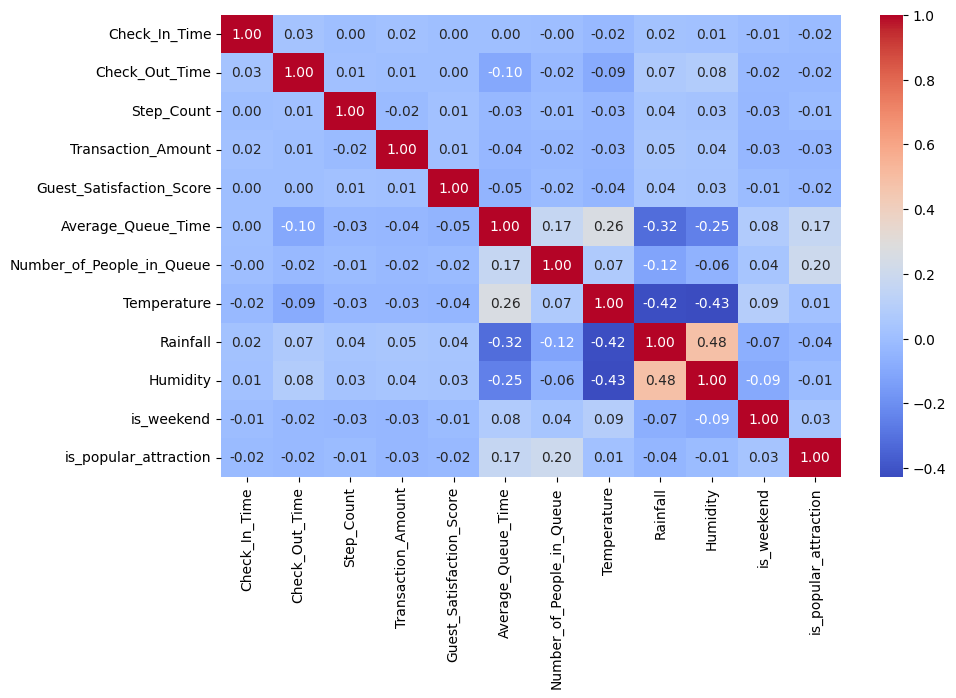

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

df_iot = load_iot_data()
correlation_matrix = df_iot.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

features = ['Guest_Satisfaction_Score', 'Average_Queue_Time', 'Check_In_Time', 
            'Check_Out_Time', 'Temperature', 'Rainfall', 'Humidity']
X = df_iot[features]
y = df_iot['Number_of_People_in_Queue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print(feature_importance)


Rainfall                    0.191026
Humidity                    0.181466
Temperature                 0.175062
Guest_Satisfaction_Score    0.172030
Average_Queue_Time          0.147559
Check_Out_Time              0.070382
Check_In_Time               0.062475
dtype: float64


## Load weather data

In [18]:
import requests
import pandas as pd
from datetime import datetime

def fetch_weather_data():
    """
    Fetches weather data (rainfall, temperature, humidity, wind speed) for the 15th of each month from June to December 2024.
    
    Returns:
        pd.DataFrame: DataFrame containing weather data for specific dates.
    """
    base_url = "https://api.data.gov.sg/v1/environment/"
    weather_types = ["rainfall", "air-temperature", "relative-humidity", "wind-speed"]
    dates = [f"2024-{str(month).zfill(2)}-15" for month in range(6, 13)]  # ['2024-06-15', '2024-07-15', ..., '2024-12-15']
    
    all_data = []

    for date_str in dates:
        print(f"Fetching data for: {date_str}")
        daily_data = {"date": date_str}
        
        for weather_type in weather_types:
            url = f"{base_url}{weather_type}"
            params = {"date": date_str}
            response = requests.get(url, params=params)
            
            if response.status_code == 200:
                try:
                    data = response.json()
                    readings = data["items"][0]["readings"]
                    
                    # Compute average value across stations
                    avg_value = sum(d["value"] for d in readings) / len(readings)
                    daily_data[weather_type] = avg_value
                
                except (KeyError, IndexError):
                    print(f"Missing data for {weather_type} on {date_str}")
                    daily_data[weather_type] = None
            else:
                print(f"Error fetching {weather_type} for {date_str}: {response.status_code}")
                daily_data[weather_type] = None
        
        all_data.append(daily_data)

    # Convert to DataFrame
    df_weather = pd.DataFrame(all_data)
    
    # Save to CSV
    df_weather.to_csv("weather_data_mid_month_2024.csv", index=False)
    print("Weather data saved to weather_data_mid_month_2024.csv")
    
    return df_weather

# Run the function
df_weather = fetch_weather_data()
print(df_weather)


Fetching data for: 2024-06-15
Fetching data for: 2024-07-15
Fetching data for: 2024-08-15
Fetching data for: 2024-09-15
Fetching data for: 2024-10-15
Fetching data for: 2024-11-15
Fetching data for: 2024-12-15
Weather data saved to weather_data_mid_month_2024.csv
         date  rainfall  air-temperature  relative-humidity  wind-speed
0  2024-06-15       0.0        27.825000          85.683333    2.280000
1  2024-07-15       0.0        28.530769          75.515385    2.860000
2  2024-08-15       0.0        26.725000          87.516667    1.622222
3  2024-09-15       0.0        28.657143          71.814286    3.458333
4  2024-10-15       0.0        26.383333          81.041667    2.063636
5  2024-11-15       0.0        26.846667          87.506667    1.500000
6  2024-12-15       0.0        27.871429          83.064286    3.128571
